In [2]:
import numpy as np
import pandas as pd

import emcee
import corner

import os
CWD = "/".join(os.getcwd().split("/")[:-2])

import matplotlib.pyplot as plt
%matplotlib inline

import astropy.units as u
from astropy.constants import R_sun

import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))/(sig * np.sqrt(2) * np.pi)


# Plot Percentiles

In [ ]:
.57/np.pi*180

In [22]:
res = pd.read_csv(f"{CWD}/analysis/results/mcmc/mcmcoutput.csv", skiprows=11,)
res = res[res.index%2==0]
res

,date,ID,burnin,steps,walkers,nparam,t01_p16,t01_p50,t01_p84,theta_a_p16,...,radius_p16,radius_p50,radius_p84,ED_distr1_p16,ED_distr1_p50,ED_distr1_p84,Eflare1_p16,Eflare1_p50,Eflare1_p84,Unnamed: 33
0,11_02_2020_10_07,237880881a,50000,179518,32,9,1331.66385286484,1331.66387092831,1331.66388771161,57.8612779564277,...,42.0156762314836,42.2101200921295,42.3355575633648,4938.51329208914,4987.24302575895,5032.02783735048,4.38080165241916E+034,4.42402828463753E+034,4.46375549908843E+034,NaN
2,11_02_2020_10_07,237880881b,50000,179518,32,9,1331.82639712407,1331.82653874281,1331.8266845448,57.8612779564277,...,16.7260289402344,16.7978357921099,16.890825147391,4688.78532171532,4724.38228953209,4773.58940753415,4.15927573144586E+034,4.19085269524235E+034,4.23450280026476E+034,NaN
4,11_02_2020_11_16,237880881a,50000,126742,32,10,1331.66400897832,1331.66405852341,1331.66408293647,13.5378094966208,...,46.8267524633738,53.5025151861576,74.6806472911025,6493.35337741692,9288.3462142352,13454.9483964226,5.76005196768358E+034,8.23940324484771E+034,1.19354665426703E+035,NaN
6,11_02_2020_11_16,237880881b,50000,126742,32,10,1331.82436563852,1331.82462120353,1331.82613215887,40.8909703163573,...,17.1097952600288,19.3717278583333,20.3491014571879,4349.44196217513,5487.60128869995,5992.37039293116,3.85825478398938E+034,4.86788054855767E+034,5.31564553269742E+034,NaN
8,20_02_2020_12_04,100004076,10000,124029,32,6,1358.52981676081,1358.53172464267,1358.5340692505,40.5209765788816,...,3.09011061200478,3.24944312341279,3.76938921593487,6784.64051005247,7273.56889869035,9857.081303384,7.59564387034969E+032,8.14301641170909E+032,1.10353494884003E+033,NaN
10,20_02_2020_12_04,100004076,10000,152662,32,6,1358.529805375,1358.53171208421,1358.53405297389,40.4289679174825,...,3.0903564926845,3.24998431200951,3.76729380422625,6785.9709603428,7274.6686477241,9830.99409564446,7.59713335628156E+032,8.14424761946353E+032,1.10061439410661E+033,NaN
12,20_02_2020_12_04,100004076,13333,671208,32,6,1358.5298109089,1358.5317030778,1358.5340358598,40.0038205850306,...,3.09167795756382,3.25609415437842,3.86620330191074,6791.67300350689,7299.79444366914,10336.6014270091,7.60351699431569E+032,8.17237683245202E+032,1.1572189145907E+033,NaN
14,25_02_2020_14_07,100004076,1061,92319,32,6,1358.51233301965,1358.5126253123,1358.51287934308,-10.768743572576,...,20.9683009855865,24.167541730899,28.4448841651274,54010.2682752181,70221.7587398271,95724.9360480392,6.04663964955499E+033,7.86157307151441E+033,1.07167435423529E+034,NaN
16,11_02_2020_10_07,237880881a,70000,379412,32,9,1331.66385330844,1331.663871178,1331.66388806014,57.88238108747,...,42.0229969440751,42.2091339340166,42.3335816199884,4939.68343134675,4987.68377530828,5031.90696142987,4.38183964658666E+034,4.42441925986424E+034,4.46364827381607E+034,NaN
18,11_02_2020_10_07,237880881b,70000,379412,32,9,1331.82639702057,1331.82654156411,1331.82668484937,57.88238108747,...,16.7244657391839,16.7954079913532,16.8877331290541,4689.66150574216,4725.07703798545,4772.07988630645,4.16005296706427E+034,4.19146898500255E+034,4.23316375089959E+034,NaN


In [23]:
res = res.loc[[4,6,20,24,26,30],]
res

,date,ID,burnin,steps,walkers,nparam,t01_p16,t01_p50,t01_p84,theta_a_p16,...,radius_p16,radius_p50,radius_p84,ED_distr1_p16,ED_distr1_p50,ED_distr1_p84,Eflare1_p16,Eflare1_p50,Eflare1_p84,Unnamed: 33
4,11_02_2020_11_16,237880881a,50000,126742,32,10,1331.66400897832,1331.66405852341,1331.66408293647,13.5378094966208,...,46.8267524633738,53.5025151861576,74.6806472911025,6493.35337741692,9288.3462142352,13454.9483964226,5.76005196768358E+034,8.23940324484771E+034,1.19354665426703E+035,NaN
6,11_02_2020_11_16,237880881b,50000,126742,32,10,1331.82436563852,1331.82462120353,1331.82613215887,40.8909703163573,...,17.1097952600288,19.3717278583333,20.3491014571879,4349.44196217513,5487.60128869995,5992.37039293116,3.85825478398938E+034,4.86788054855767E+034,5.31564553269742E+034,NaN
20,06_03_2020_10_16,100004076,150000,590751,32,6,1358.51221233685,1358.51274040472,1358.51328990776,-14.5867123740818,...,15.8347733112126,20.5015978036307,32.9827966335637,30931.7893387612,46581.3536108787,114778.001837465,3.46292269637279E+033,5.21494650310258E+033,1.28498013242706E+034,NaN
22,08_07_2020_11_48,44984200,150,22156,32,6,1588.02720287295,1588.0274767793,1588.02775393296,67.8097289772427,...,5.19943320880413,5.23847856871522,5.28122245490863,3283.49730651743,3335.05379195772,3391.31640249332,3.05642734579997E+033,3.10441844712972E+033,3.15679022189737E+033,NaN
24,11_02_2020_10_07,237880881a,34903,1576002,32,9,1331.66385326558,1331.66387122321,1331.66388820846,57.8795686074588,...,42.0206628759492,42.2100433396356,42.333080319898,4939.39368169012,4987.5330189568,5031.50265263991,4.38158261867168E+034,4.42428552859035E+034,4.46328962405442E+034,NaN
26,11_02_2020_10_07,237880881b,34903,1576002,32,9,1331.82639427697,1331.82654088914,1331.82668586329,57.8795686074588,...,16.7247046012945,16.7956777286697,16.8856247953146,4689.25209389904,4724.91710976565,4772.26816371612,4.15968979054276E+034,4.19132711764934E+034,4.23333076593805E+034,NaN
30,08_07_2020_11_48,277539431,1861,1013992,32,6,1641.8428495283,1641.84461193767,1641.8458447766,81.6016129258368,...,16.3701682013347,18.0028165265795,19.5463976578376,23679.2336289383,28430.4519399802,33267.9006130536,2.6671583118474E+034,3.20232138377259E+034,3.74719718671053E+034,NaN


In [ ]:
plt.figure(figsize=(8,5))
x = np.linspace(0,90,300)
for i, row in res.iterrows():
    a, up, lo = float(row.theta_a_p50), float(row.theta_a_p84), float(row.theta_a_p16)
    print(up-a,a-lo,row.ID,row.nparam)
    plt.plot(x, gaussian(x,a,(up-lo)/2), label=f"{row.ID} ({row.nparam})")
plt.legend(loc=2, frameon=False)
plt.xlim(0,90)
plt.xlabel(r"flare latitude $\theta$ [deg]")
plt.ylabel(r"probability")
plt.tight_layout()
plt.savefig(f"{CWD}/analysis/plots/flare_latitudes.png",dpi=300)

In [ ]:
gaussian(x,a,(up-lo)/2)

# Plot Posteriors and Calculate physical properties

In [2]:
columns = ["t0_d","latitude_deg","a","fwhm_d","i_deg","phase_deg"]

In [4]:
# What dataset do you want to analyse?
ID = 237880881#277539431#44984200#230120143##212035340 #230120143#
tstamp = "11_02_2020_10_07"#"08_07_2020_11_48"#"20_02_2020_12_04"#'13_12_2019_10_18'#'27_01_2020_12_28'#

props = pd.read_csv(f"{CWD}/data/summary/everything.csv")
target = props[props.ID == ID].iloc[0]

# Pick up the input parameters
inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")
inits = inits[(inits.ID == str(ID)+"a") & (inits.tstamp==tstamp)].iloc[0]

# Pick up the LC
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")

qlum = inits.qlum_erg_s * u.erg / u.s
Fth = inits.Fth * u.erg/ u.cm**2 / u.s
median = inits['median']
R = inits.R_Rsun * R_sun

In [11]:
resultframe = pd.read_csv(f"{CWD}/analysis/results/mcmc/{target.ID}_{tstamp}_converted_mcmc_sample.csv")

In [21]:
resultframe.columns

Index(['t0_d_a', 't0_d_b', 'latitude_deg', 'a_a', 'a_b', 'fwhm_d_a', 'fwhm_b',
       'i_deg', 'phase_deg', 'rad_rsun', 'ED_s', 'rad_rsun_a', 'ED_s_a'],
      dtype='object')

In [19]:
suffix = "_a"
from funcs.model import calculate_angular_radius, calculate_ED

percentiles = [16,50,84]

resultframe[f"rad_rsun{suffix}"] = resultframe.apply(lambda x: calculate_angular_radius(Fth, x[f"a{suffix}"], qlum, R), axis=1)

resultframe[f"ED_s{suffix}"] = resultframe.apply(lambda x: calculate_ED(lc.t.values, 
                                                                   x[f"t0_d{suffix}"], 
                                                                   x[f"fwhm_d{suffix}"], 
                                                                   x[f"a{suffix}"]),
                                           axis=1)

In [20]:
resultframe.to_csv(f"{CWD}/analysis/results/mcmc/{target.ID}_{tstamp}_converted_mcmc_sample.csv", index=False)

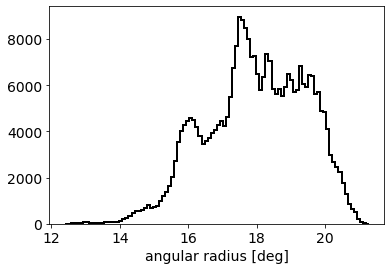

In [16]:
plt.hist(resultframe.rad_rsun.values,bins=100, histtype="step",color="k",linewidth=2);
plt.xlabel("angular radius [deg]")
radius_p = np.percentile(resultframe.rad_rsun.values, percentiles, axis=0)
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_active_region_radii.png",dpi=300)

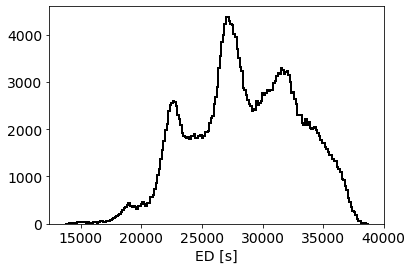

In [17]:
ED_distr = resultframe.ED_s.values
ED_distr_p = np.percentile(ED_distr, percentiles, axis=0)
plt.hist(ED_distr,bins=200, histtype="step",color="k",linewidth=2);
plt.xlabel("ED [s]")
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_flare_ED.png",dpi=300)

In [ ]:
resultframe = pd.read_csv(f"{CWD}/analysis/results/mcmc/{target.ID}_{tstamp}_converted_mcmc_sample.csv")

In [21]:
t0_p, theta_a_p, a_p, fwhm_p, i_p, phi0_p = map(lambda v: (v[0], v[1], v[2]),
                                                   zip(*np.percentile(resultframe[["t0_d","latitude_deg","a","fwhm_d","i_deg","phase_deg"]].values,
                                                                      percentiles,
                                                       axis=0)))

with open(f"{CWD}/analysis/results/mcmc/mcmcoutput.csv","a") as f:
    #Add more lines here
    
    out = f"{tstamp},{target.ID},"
    firstout = f"date,ID,"
    for i in ['t0_p', 'theta_a_p', 'a_p', 'fwhm_p', 'i_p', 'phi0_p', 'radius_p', 'ED_distr_p', 'Eflare_p']:
        firstout += f"{i}{percentiles[0]},{i}{percentiles[1]},{i}{percentiles[2]},"
    for i in [t0_p, theta_a_p, a_p, fwhm_p, i_p, phi0_p, radius_p, ED_distr_p, (ED_distr_p*qlum).value ]:
        out += f"{i[0]},{i[1]},{i[2]},"
    out += "\n"
    firstout += "\n"
    f.write(firstout)
    f.write(out)

In [25]:
1.5e6/60/60/24

17.36111111111111